In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import datetime

In [ ]:
torch.cuda.is_available() # gou ile çalışıyor mu?

False

In [ ]:
# Get the current date and time
firstNow = datetime.datetime.now()

# Print the results to the screen
print("Şu anki tarih ve saat: ", firstNow)


Şu anki tarih ve saat:  2023-04-08 20:57:30.334055


In [ ]:
# Seed ayarlama
torch.manual_seed(190401008)
# Batch size seçilir
batch_size = 16

In [ ]:
# Veri setini yükleme
trainData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cure_the_princess_train.csv")

# Veri setini yükleme
testData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cure_the_princess_test.csv")

# Veri setini yükleme
validationData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cure_the_princess_validation.csv")

In [ ]:
trainData.shape, testData.shape, validationData.shape

((1252, 14), (772, 14), (314, 14))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# TensorDataset kullanarak train, test ve validation setlerini oluşturuyoruz
train_inputs = trainData.drop('Cured', axis=1).values
train_labels = trainData['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = validationData.drop('Cured', axis=1).values
val_labels = validationData['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = testData.drop('Cured', axis=1).values
test_labels = testData['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))


# DataLoader kullanarak train, test ve validation setlerini batch'ler halinde modele veriyoruz
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1) # 1st hidden layer
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2) # 2nd hidden layer
        self.output = nn.Linear(hidden_size2, output_size) # output layer

    def forward(self, x):
        x = torch.relu(self.hidden1(x)) # Apply ReLU activation function in the 1st hidden layer
        x = torch.relu(self.hidden2(x)) # Apply ReLU activation function in the 2nd hidden layer
        x = torch.sigmoid(self.output(x)) # Apply sigmoid activation function in the output layer
        return x


In [ ]:
input_size = len(trainData.columns) - 1 # Number of input features, excluding the target column
hidden_size1 = 100 # Number of units in the 1st hidden layer
hidden_size2 = 50 # Number of units in the 2nd hidden layer
output_size = 2 # Number of output units (for binary classification)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if available, else use CPU

# Define the MLP model
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
# Send the model to the device (GPU or CPU)
model = model.to(device)


In [ ]:
input_size

13

In [ ]:
# Define the Cross Entropy loss function
criterion = nn.CrossEntropyLoss()

# Define the SGD optimizer
# We can adjust the learning rate to prevent overfitting
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 50
train_loss_list = []
validation_loss_list = []
patience=5
best_val_loss = None  # define best_val_loss 
lastStop=0

for epoch in range(num_epochs):

    # Train the model
    model.train()  # train mode on
    train_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

        # Print loss every few iterations
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}],  Loss: {loss.item():.4f}")
        

    train_loss_list.append(train_loss / len(train_loader.dataset))  # add list for figure
    #train_loss_list.append(loss.item())
    train_loss /= len(train_loader.dataset)
    train_acc = 100 * correct / total

    

    # Evaluate the model on validation set every epoch
    model.eval()
    val_loss=0.0
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass and calculate accuracy
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # predicted = torch.round(outputs)
            # predicted = predicted.view(-1)  Make output one-dimensional
            val_loss += loss.item() * inputs.size(0)  # Collect Losses
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_loss_list.append(val_loss / len(val_loader.dataset))
        val_loss/= len(val_loader.dataset) # Calculate the average by dividing the losses by the number of data
        val_acc = correct / total
         # print(f"Validation accuracy after epoch {epoch+1}: {val_acc:.4f}")


        #EarlyStopping
        val_score=val_loss

        if best_val_loss is None:
          patience_counter=0
          best_val_loss=val_score       # Keep patience length in memory
          torch.save(model.state_dict(),"checkpoint.pt")
        elif best_val_loss<val_score:     # patience counter
          patience_counter+=1
          print("Earlystopping Patience Counter",patience_counter)
          if patience_counter==patience:           
            break
        else:
          best_val_loss=val_score
          torch.save(model.state_dict(),"checkpoint.pt")        # keeps the best model
          patience_counter=0        # reset patience after we get the best model

        lastStop=epoch+1
        #print(f"Validation accuracy after epoch {epoch+1}: {val_acc:.4f}")
    
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/50], Train Loss: 0.6161, Train Acc: 71.01, Val Loss: 0.5445, Val Acc: 0.8408
Epoch [2/50], Train Loss: 0.5353, Train Acc: 82.19, Val Loss: 0.4936, Val Acc: 0.8567
Epoch [3/50], Train Loss: 0.4993, Train Acc: 84.50, Val Loss: 0.4651, Val Acc: 0.8758
Epoch [4/50], Train Loss: 0.4778, Train Acc: 85.78, Val Loss: 0.4603, Val Acc: 0.8758
Epoch [5/50], Train Loss: 0.4618, Train Acc: 86.74, Val Loss: 0.4309, Val Acc: 0.9172
Earlystopping Patience Counter 1
Epoch [6/50], Train Loss: 0.4527, Train Acc: 88.10, Val Loss: 0.4339, Val Acc: 0.8854
Epoch [7/50], Train Loss: 0.4474, Train Acc: 88.42, Val Loss: 0.4143, Val Acc: 0.9331
Epoch [8/50], Train Loss: 0.4405, Train Acc: 88.74, Val Loss: 0.4092, Val Acc: 0.9268
Earlystopping Patience Counter 1
Epoch [9/50], Train Loss: 0.4327, Train Acc: 89.14, Val Loss: 0.4114, Val Acc: 0.8949
Epoch [10/50], Train Loss: 0.4298, Train Acc: 89.22, Val Loss: 0.3991, Val Acc: 0.9299
Earlystopping Patience Counter 1
Epoch [11/50], Train Loss: 0.4276, Train

In [ ]:
total, correct, lastStop, num_epochs

(314, 292, 23, 50)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

newModel = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

# define best model path
model_path = '/content/checkpoint.pt'

# upload best model
newModel.load_state_dict(torch.load(model_path))

# Set the model in evaluation mode
newModel.eval()

# Loop over the test set and make predictions
with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = newModel(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9145
Precision: 0.9086
Recall: 0.9227
F1 Score: 0.9156


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Set the model in evaluation mode
model.eval()

# Loop over the test set and make predictions
with torch.no_grad():
    true_labels = []
    predicted_labels = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.cpu().numpy().tolist()
        predicted_labels += predicted.cpu().numpy().tolist()

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9093
Precision: 0.9569
Recall: 0.8582
F1 Score: 0.9049


In [ ]:
test_dataset[5]       #tensor(x) x, 0 veya 1 olacak, burada tensor 1 geldi.

(tensor([15.7000, 17.5000, 14.4000, 12.2000, 11.9000,  4.2000,  1.7000,  6.4000,
         20.9000, 12.5000, 21.1000, 15.6000, 12.4000]),
 tensor(1))

In [ ]:
outputs = model(test_dataset[5][0])         #(0,1) tensor değerine göre label1 indeğeri label0 ın değerinden büyük olduğu için modelimiz doğru çalışıyor.
outputs

tensor([0.2638, 0.6852], grad_fn=<SigmoidBackward0>)

```
plt.plot(x, y, color='color', linestyle='linestyle', label='label')
```

Burada, x ve y veri dizileri, çizgi grafiğin x ve y eksenindeki değerleridir. color parametresi, çizgi rengini belirler. Örneğin, 'red' (kırmızı), 'blue' (mavi), 'green' (yeşil) gibi renk adları veya 'r', 'b', 'g' gibi kısa renk kodları kullanabilirsiniz. linestyle parametresi, çizgi stilini belirler. Örneğin, '-' (sürekli çizgi), '--' (kesik çizgi), ':' (noktalı çizgi), '-.' (noktalı kesik çizgi) gibi stil kodları kullanabilirsiniz. label parametresi, çizgi için bir etiket belirler.

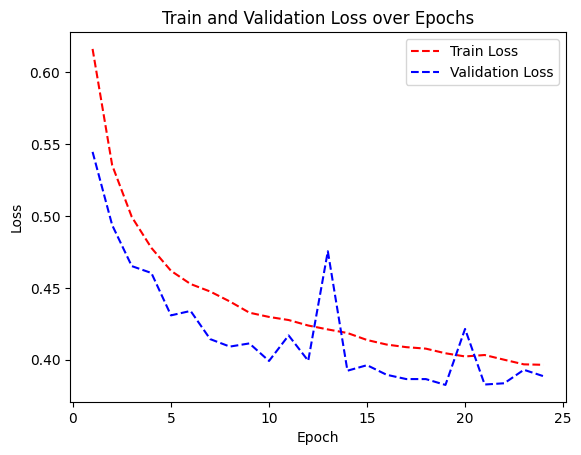

In [ ]:
import matplotlib.pyplot as plt

num_epochs = lastStop + 1
#num_epochs = 50
#learning rate değiştiğinde num_epoch a +1 ekle

# Create the training loss plot
plt.plot(range(1, num_epochs+1), train_loss_list, color='red', linestyle='dashed', label="Train Loss")

# Create the validation loss plot
plt.plot(range(1, num_epochs+1), validation_loss_list, color='blue', linestyle='dashed', label="Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()  # Show the labels
plt.show()


In [ ]:
# Get the current date and time
lastNow = datetime.datetime.now()

# Print the results to the screen
print(f"Code execution time: {device} ", lastNow-firstNow)

#Code execution time: cuda  0:00:10.617068

Code execution time: cpu  0:02:51.144148
